<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/hyougo/hyougo_yousei_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 8.3MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120191 sha256=078e363222c3d351f8db9bb16ca06b2ba1515e837cf2b31a78a72205b84627b2
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


In [2]:
import pathlib
import re
from urllib.parse import urljoin

In [3]:
import requests
from bs4 import BeautifulSoup

# スクレイピング

In [4]:
def get_excel(url):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, "html.parser")
    tag = soup.find("a", href=re.compile("xls[mx]?$"))

    if tag:
        link = urljoin(url, tag.get("href"))
        p = get_file(link, "data")

        return p
    else:
        raise FileNotFoundError("Excelファイルが見つかりません")

In [5]:
def get_file(url, dir="."):
    
    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [6]:
import pandas as pd

In [7]:
p = get_excel("https://web.pref.hyogo.lg.jp/kk03/corona_kanjyajyokyo.html")

df_kanja = pd.read_excel(
    p,
    skiprows=3,
    skipfooter=2,
    usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    dtype={"番号": "Int64"},
)

In [8]:
df_kanja.shape

(1639, 10)

In [9]:
df_kanja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639 entries, 0 to 1638
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   番号      1637 non-null   Int64 
 1   発表日     1637 non-null   object
 2   年代      1637 non-null   object
 3   性別      1637 non-null   object
 4   管轄      1637 non-null   object
 5   居住地     1637 non-null   object
 6   職業      1636 non-null   object
 7   発症日     1637 non-null   object
 8   渡航歴     1637 non-null   object
 9   備考欄     1636 non-null   object
dtypes: Int64(1), object(9)
memory usage: 129.8+ KB


In [10]:
df_kanja.count()

番号     1637
発表日    1637
年代     1637
性別     1637
管轄     1637
居住地    1637
職業     1636
発症日    1637
渡航歴    1637
備考欄    1636
dtype: int64

# 前処理

In [11]:
import datetime

import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.dates as mdates
import numpy as np

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [12]:
# 解像度
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [13]:
# 全列欠損を削除

df_kanja.dropna(how="all", inplace=True)

In [14]:
# 発表日

flg_is_serial = df_kanja["発表日"].astype("str").str.isdigit()

fromSerial = pd.to_datetime(
    df_kanja.loc[flg_is_serial, "発表日"].astype(float),
    unit="D",
    origin=pd.Timestamp("1899/12/30"),
)
fromString = pd.to_datetime(df_kanja.loc[~flg_is_serial, "発表日"])

df_kanja["発表日"] = pd.concat([fromString, fromSerial])

In [15]:
# 除外
df_kanja.set_index("番号", inplace=True)
df_kanja.drop(738, inplace=True)

In [16]:
# 備考欄

df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("\n", "")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("NO.|N0.|NO,|N0,|No,", "No.")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("・", "、")
df_kanja["備考欄"] = df_kanja["備考欄"].fillna("")

In [17]:
# ステータス

df_kanja["ステータス"] = df_kanja["発症日"].mask(df_kanja["発症日"].astype("str").str.isdigit(), "症状あり")

In [18]:
# 発症日

df_kanja["発症日"] = df_kanja["発症日"].where(df_kanja["発症日"].astype("str").str.isdigit())
df_kanja["発症日"] = pd.to_datetime(df_kanja["発症日"].astype(float), unit="D", origin=pd.Timestamp("1899/12/30"))

In [19]:
df_kanja.to_csv("kanja.tsv", sep="\t")

# 経過日数確認

## 経過日数グラフ

Text(0.98, 0.85, 'median: 6.0')

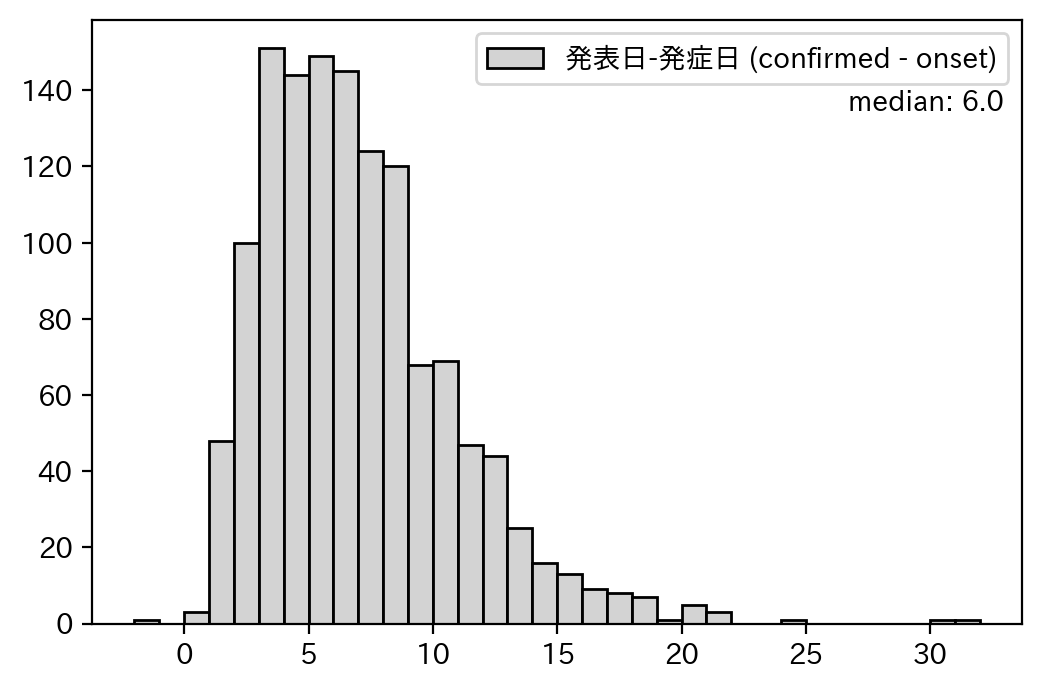

In [20]:
df_kanja["経過日数"] = (df_kanja["発表日"] - df_kanja["発症日"]).dt.days

df_kanja["経過日数"].dropna(inplace=True)

fig, ax = plt.subplots()
ax.hist(df_kanja["経過日数"], bins=np.arange(min(df_kanja["経過日数"]), max(df_kanja["経過日数"])+2), color="lightgray", edgecolor="black")
ax.legend(['発表日-発症日 (confirmed - onset)'])
ax.text(0.98, 0.85, 'median: ' + str(np.median(df_kanja["経過日数"])), horizontalalignment='right', transform=ax.transAxes)

## 経過日数一覧

In [21]:
df_kanja["経過日数"].value_counts().sort_index()

-2.0       1
 0.0       3
 1.0      48
 2.0     100
 3.0     151
 4.0     144
 5.0     149
 6.0     145
 7.0     124
 8.0     120
 9.0      68
 10.0     69
 11.0     47
 12.0     44
 13.0     25
 14.0     16
 15.0     13
 16.0      9
 17.0      8
 18.0      7
 19.0      1
 20.0      5
 21.0      3
 24.0      1
 30.0      1
 31.0      1
Name: 経過日数, dtype: int64

# 発症日グラフ

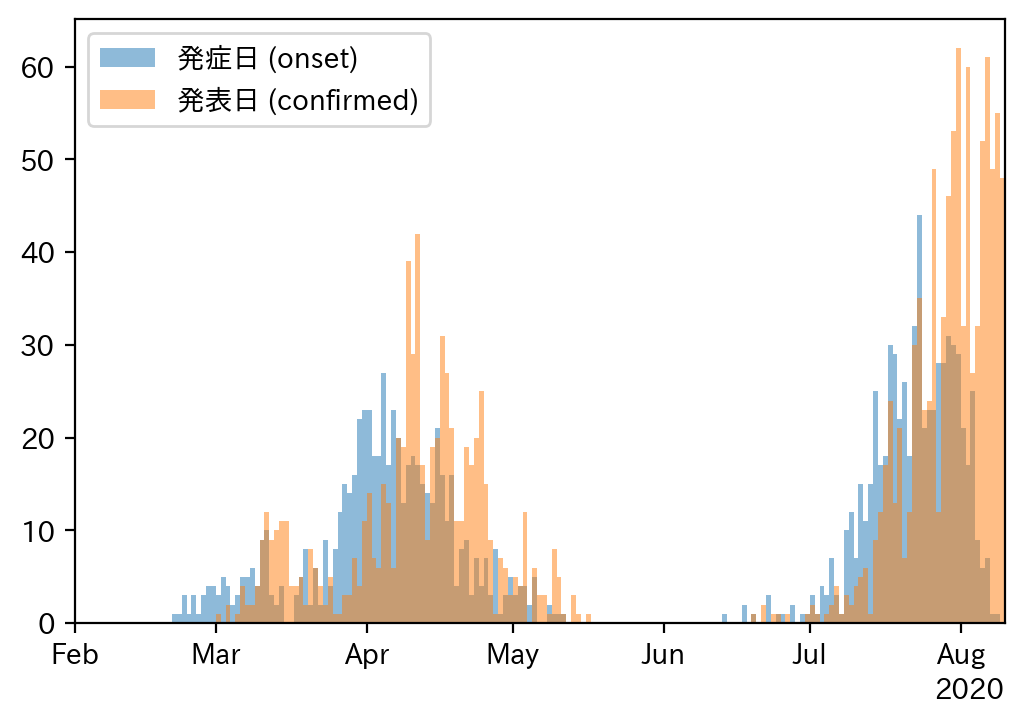

In [22]:
b = np.arange(min(min(df_kanja['発表日']), min(df_kanja['発症日'])),
              max(max(df_kanja['発表日']), max(df_kanja['発症日'])) + datetime.timedelta(days=2),
              datetime.timedelta(days=1))

fig, ax = plt.subplots()
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.hist(df_kanja['発症日'].values, bins=b, alpha=0.5) # edgecolor="black"
ax.hist(df_kanja['発表日'].values, bins=b, alpha=0.5)
ax.legend(['発症日 (onset)', '発表日 (confirmed)'])
ax.set_xlim(datetime.datetime(2020,2,1), b[-1])
fig.savefig('200312a.svg', bbox_inches="tight")

# 年代確認

## 年代別グラフ

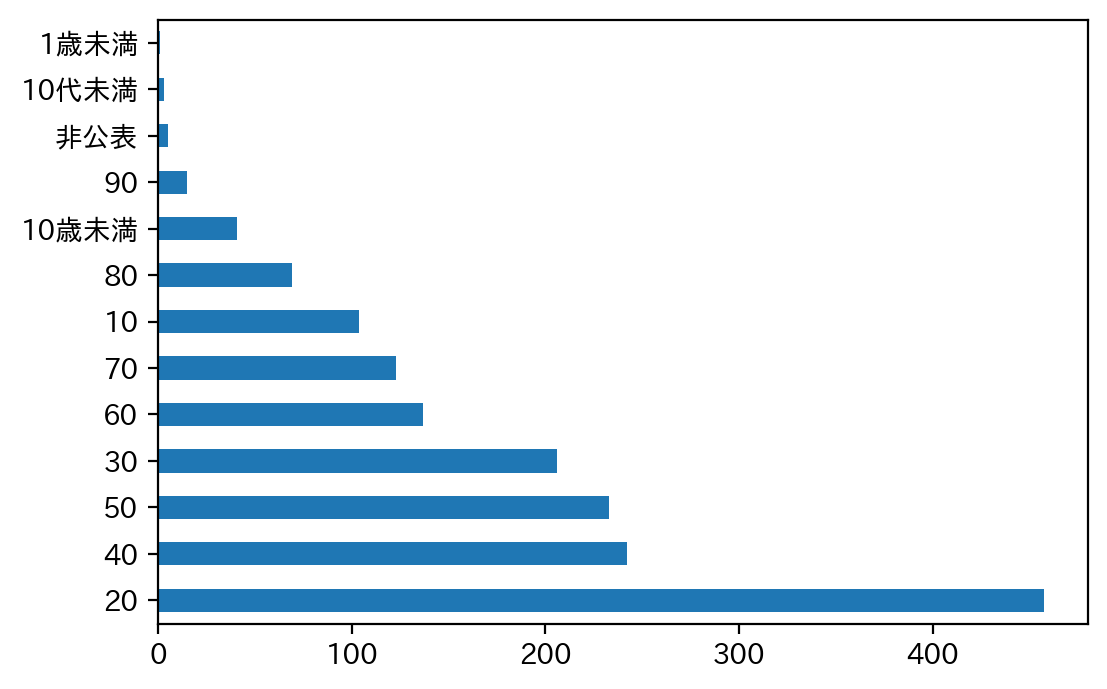

In [23]:
df_kanja["年代"].value_counts().plot.barh()

## 年代別一覧

In [24]:
df_kanja["年代"].value_counts()

20       457
40       242
50       233
30       206
60       137
70       123
10       104
80        69
10歳未満     41
90        15
非公表        5
10代未満      3
1歳未満       1
Name: 年代, dtype: int64

In [25]:
ages = ("非公表","10歳未満",10,20,30,40,50,60,70,80,90)

In [26]:
cr = pd.crosstab(df_kanja["発表日"], df_kanja["年代"], values=df_kanja["年代"], aggfunc="count").reindex(columns=ages).fillna(0).astype(int)
cr.tail(1)

年代,非公表,10歳未満,10,20,30,40,50,60,70,80,90
発表日,,,,,,,,,,,
2020-08-08,0,4,2,16,5,10,8,6,4,0,0
2020-08-09,0,1,2,12,9,9,6,4,5,0,0


# 性別確認

## 性別別グラフ

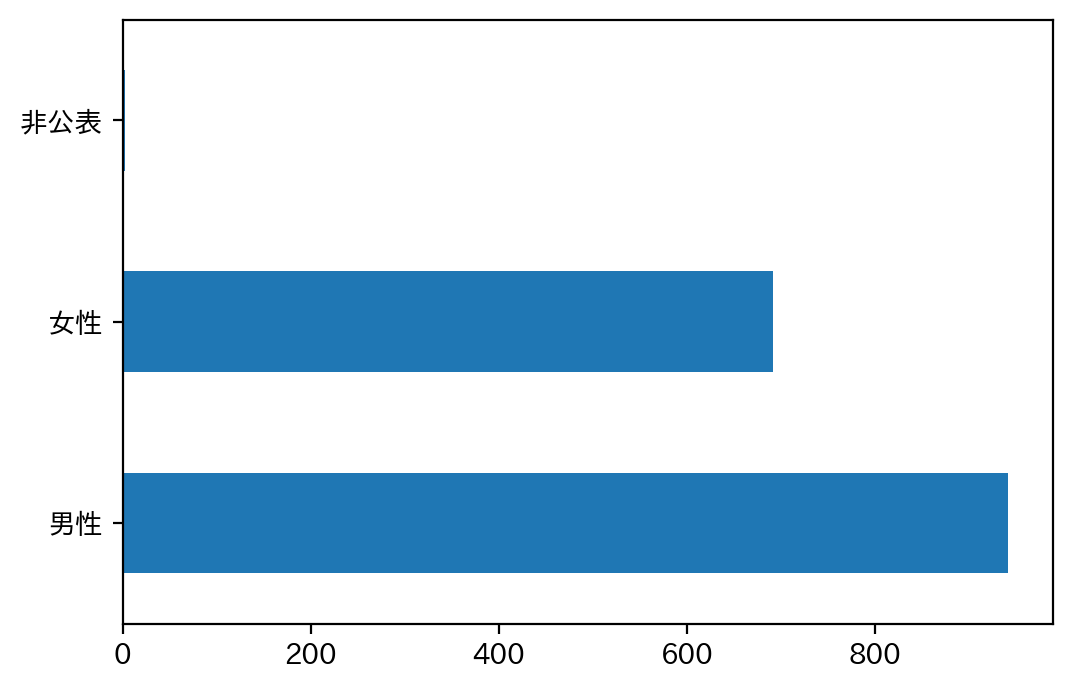

In [27]:
df_kanja["性別"].value_counts().plot.barh()

## 性別別一覧

In [28]:
df_kanja["性別"].value_counts()

男性     942
女性     692
非公表      2
Name: 性別, dtype: int64

# 居住地確認

## 居住地別グラフ

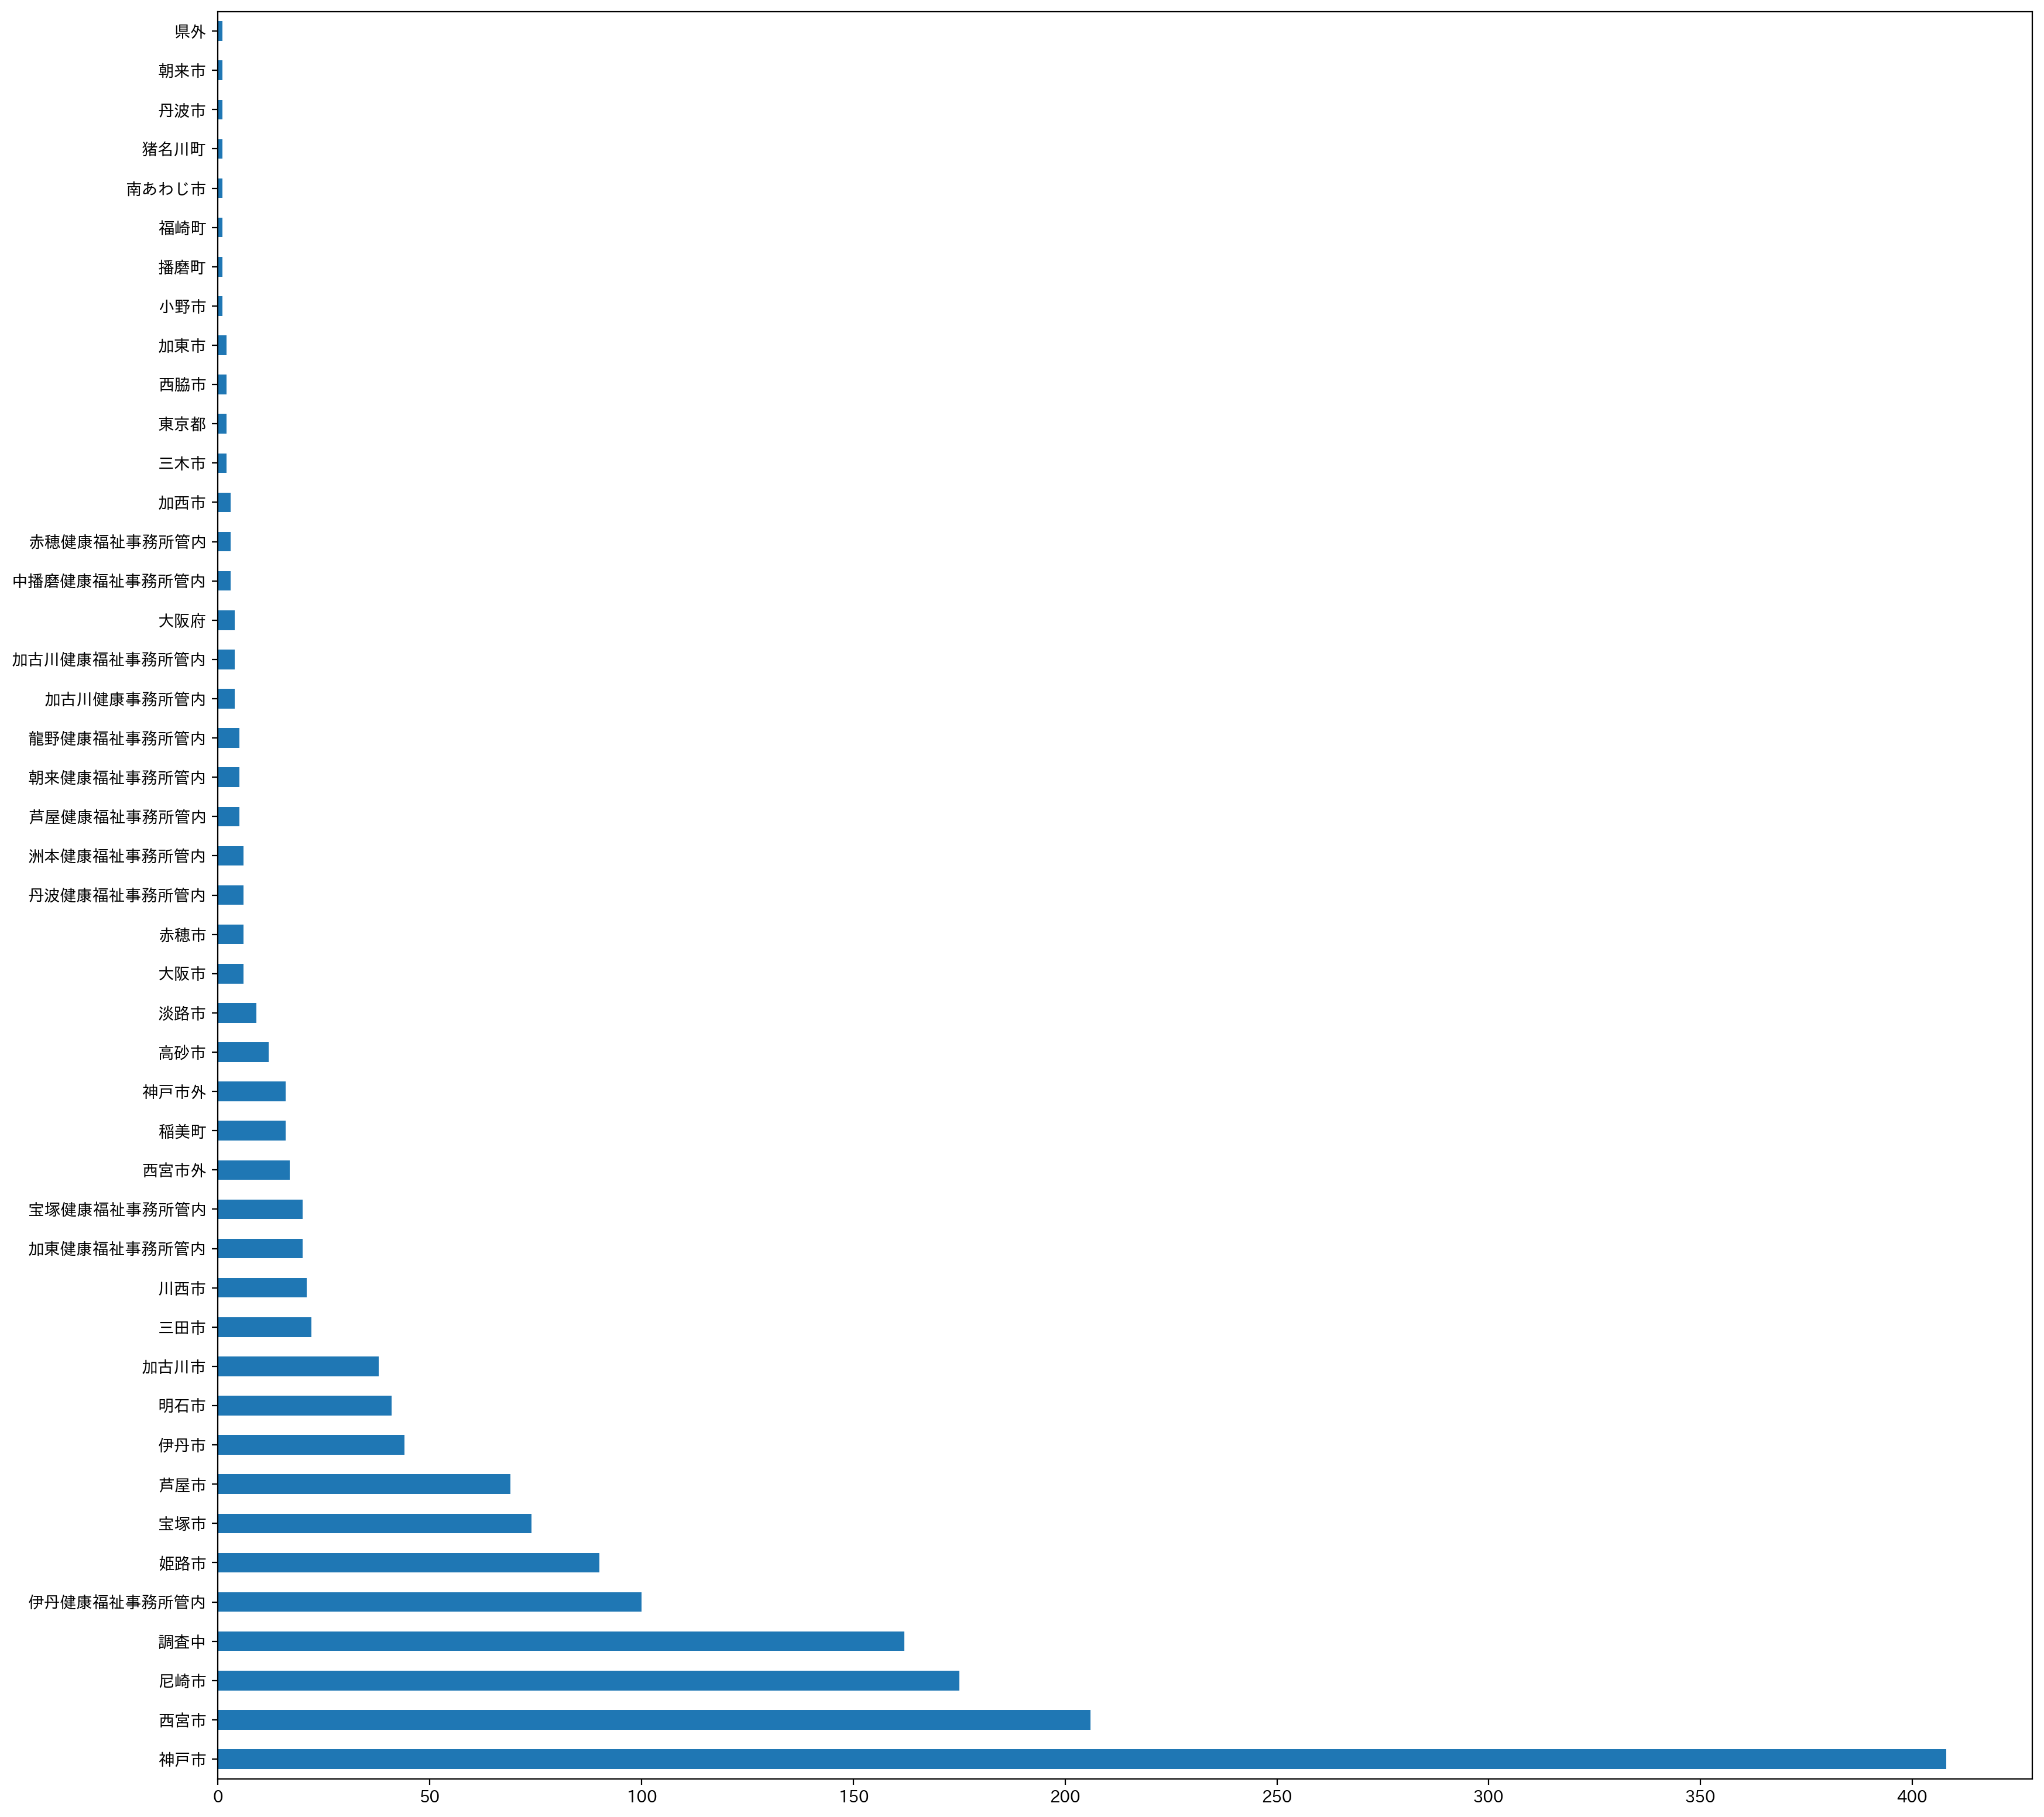

In [29]:
df_kanja["居住地"].value_counts().plot.barh(figsize=(20, 20))

## 居住地別一覧

In [30]:
df_kanja["居住地"].value_counts()

神戸市             408
西宮市             206
尼崎市             175
調査中             162
伊丹健康福祉事務所管内     100
姫路市              90
宝塚市              74
芦屋市              69
伊丹市              44
明石市              41
加古川市             38
三田市              22
川西市              21
加東健康福祉事務所管内      20
宝塚健康福祉事務所管内      20
西宮市外             17
稲美町              16
神戸市外             16
高砂市              12
淡路市               9
大阪市               6
赤穂市               6
丹波健康福祉事務所管内       6
洲本健康福祉事務所管内       6
芦屋健康福祉事務所管内       5
朝来健康福祉事務所管内       5
龍野健康福祉事務所管内       5
加古川健康事務所管内        4
加古川健康福祉事務所管内      4
大阪府               4
中播磨健康福祉事務所管内      3
赤穂健康福祉事務所管内       3
加西市               3
三木市               2
東京都               2
西脇市               2
加東市               2
小野市               1
播磨町               1
福崎町               1
南あわじ市             1
猪名川町              1
丹波市               1
朝来市               1
県外                1
Name: 居住地, dtype: int64

# 職業確認

## 職業別グラフ

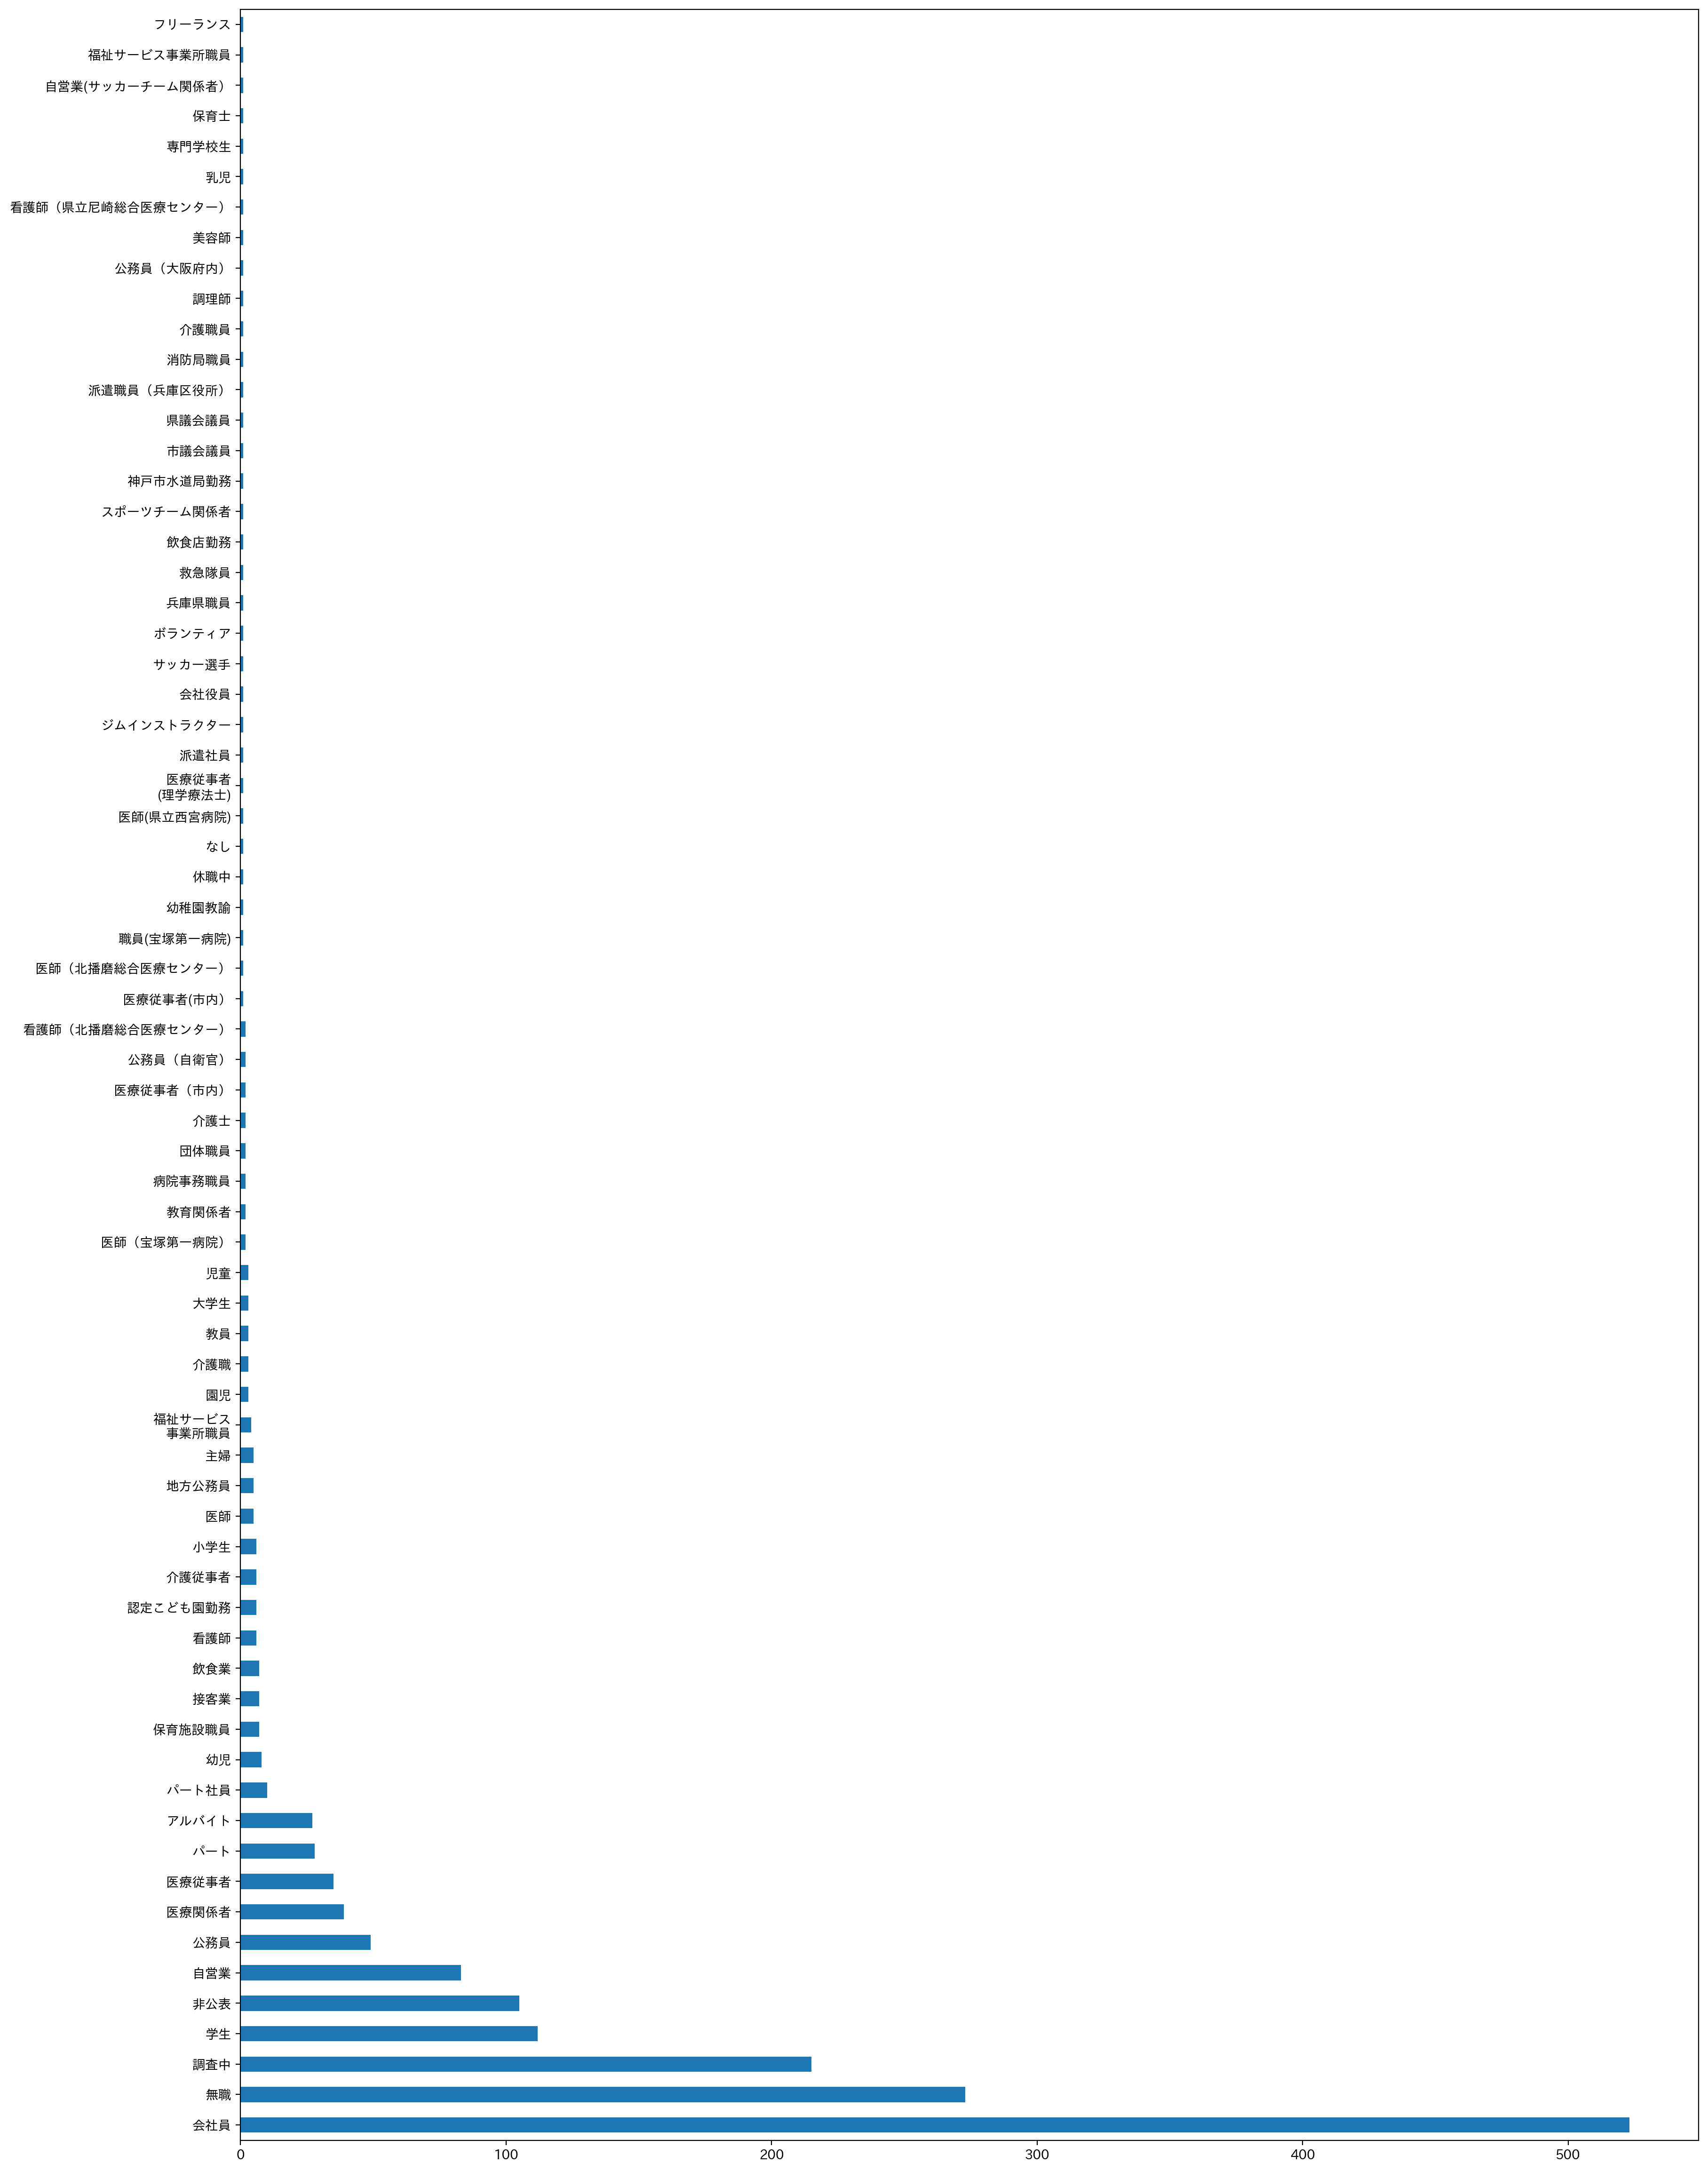

In [31]:
df_kanja["職業"].value_counts().plot.barh(figsize=(20, 30))

## 職業別一覧

In [32]:
df_kanja["職業"].value_counts()

会社員                523
無職                 273
調査中                215
学生                 112
非公表                105
                  ... 
専門学校生                1
保育士                  1
自営業(サッカーチーム関係者）      1
福祉サービス事業所職員          1
フリーランス               1
Name: 職業, Length: 70, dtype: int64

# 管轄確認

## 管轄別グラフ

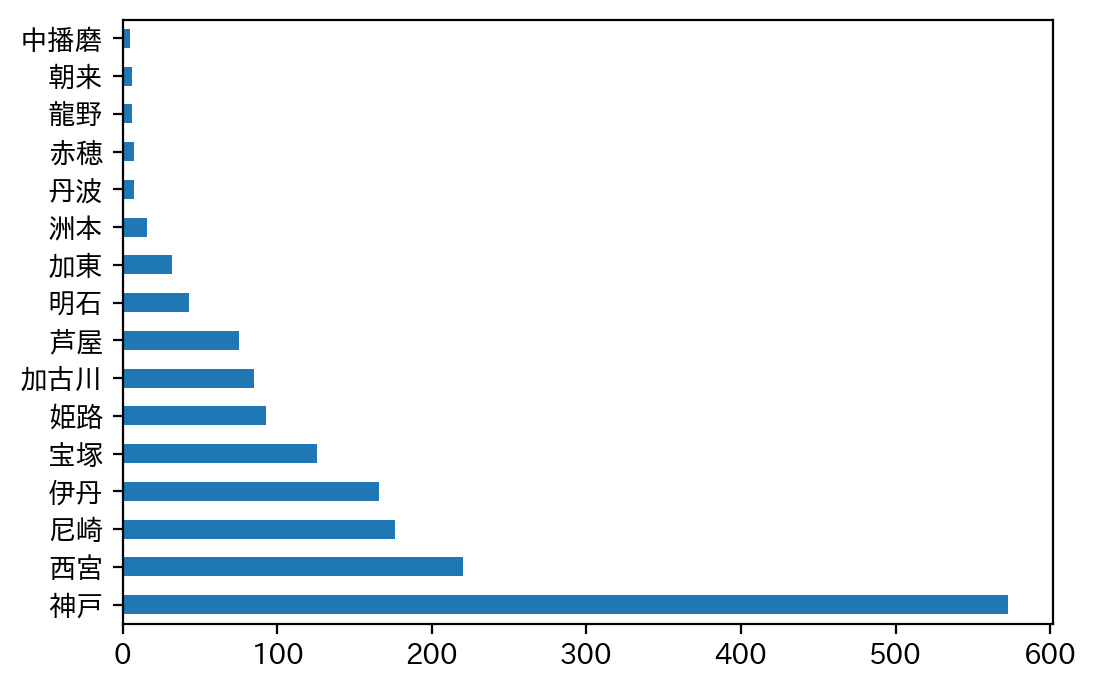

In [33]:
df_kanja["管轄"].value_counts().plot.barh()

## 管轄別一覧

In [34]:
df_kanja["管轄"].value_counts()

神戸     573
西宮     220
尼崎     176
伊丹     166
宝塚     126
姫路      93
加古川     85
芦屋      75
明石      43
加東      32
洲本      16
丹波       7
赤穂       7
龍野       6
朝来       6
中播磨      5
Name: 管轄, dtype: int64

# 最新

In [35]:
cr = pd.crosstab(df_kanja["発表日"], df_kanja["管轄"], values=df_kanja["管轄"], aggfunc="count").reindex(columns=["芦屋","宝塚","伊丹","加古川","加東","中播磨","龍野","赤穂","豊岡","朝来","丹波","洲本","神戸","姫路","尼崎","西宮","明石"]).fillna(0).astype(int)
cr.tail(1)

管轄,芦屋,宝塚,伊丹,加古川,加東,中播磨,龍野,赤穂,豊岡,朝来,丹波,洲本,神戸,姫路,尼崎,西宮,明石
発表日,,,,,,,,,,,,,,,,,
2020-08-09,1,3,3,0,0,0,2,0,0,0,0,0,18,1,17,2,1


In [36]:
cr.sum(axis=1).tail(1)

発表日
2020-08-09    48
dtype: int64

# 渡航歴確認

## 渡航歴別グラフ

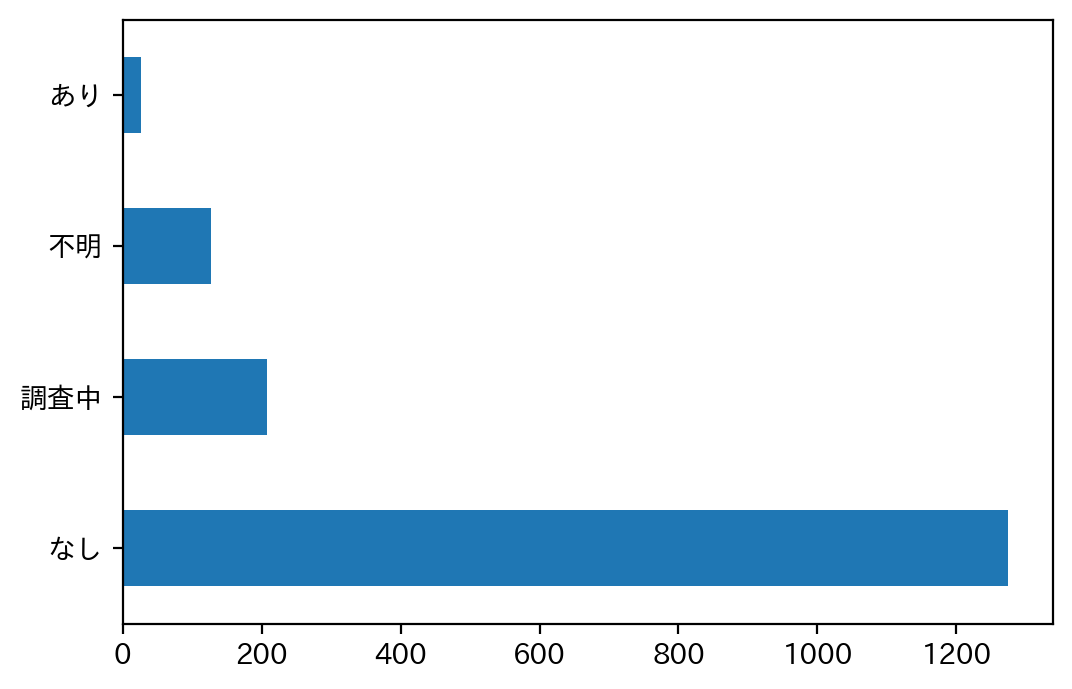

In [37]:
df_kanja["渡航歴"].value_counts().plot.barh()

## 渡航歴別一覧

In [38]:
df_kanja["渡航歴"].value_counts()

なし     1275
調査中     208
不明      127
あり       26
Name: 渡航歴, dtype: int64

# ステータス確認

## ステータス別グラフ

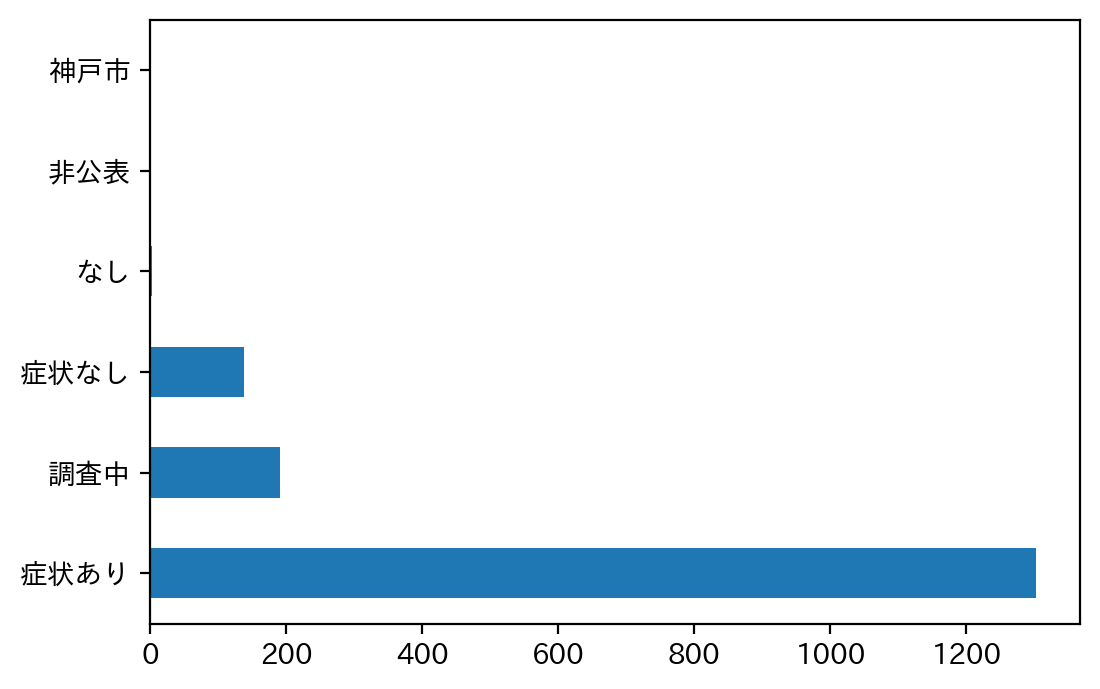

In [39]:
df_kanja["ステータス"].value_counts().plot.barh()

## ステータス別一覧

In [40]:
df_kanja["ステータス"].value_counts()

症状あり    1303
調査中      191
症状なし     138
なし         2
非公表        1
神戸市        1
Name: ステータス, dtype: int64

# 全体確認

In [41]:
df_kanja

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1637,2020-08-09,20,女性,龍野,龍野健康福祉事務所管内,非公表,2020-08-07,なし,大阪市の陽性患者の濃厚接触者,症状あり,2.0
1636,2020-08-09,20,男性,龍野,龍野健康福祉事務所管内,非公表,2020-08-08,なし,大阪市の陽性患者の濃厚接触者,症状あり,1.0
1635,2020-08-09,20,女性,伊丹,川西市,大学生,NaT,なし,No1528の濃厚接触者,症状なし,NaN
1634,2020-08-09,30,女性,伊丹,伊丹健康福祉事務所管内,パート,2020-08-05,なし,No1633の濃厚接触者,症状あり,4.0
1633,2020-08-09,30,男性,伊丹,伊丹健康福祉事務所管内,自営業,2020-07-28,なし,行動歴調査中,症状あり,12.0
...,...,...,...,...,...,...,...,...,...,...,...
5,2020-03-06,40,男性,姫路,姫路市,会社員,2020-02-23,なし,2/19に大阪のSoap operaライブに参加,症状あり,12.0
4,2020-03-05,50,女性,中播磨,福崎町,無職,2020-02-22,なし,2/15、16に大阪のライブハウスArcに参加,症状あり,12.0
3,2020-03-03,40,女性,神戸,神戸市,会社員,2020-02-21,なし,2/15、16に大阪のライブハウスArcに参加,症状あり,11.0


# ファイル保存

In [42]:
import datetime

JST = datetime.timezone(datetime.timedelta(hours=+9))

dt_now = datetime.datetime.now(JST).date().isoformat()

## 全体

In [43]:
df_kanja.to_csv("kanja.tsv", sep="\t")

## 年齢別抽出

In [44]:
# 年齢別抽出

grouped_df = df_kanja.groupby("年代")

with pd.ExcelWriter(f"陽性者一覧（年齢別）_{dt_now}.xlsx", engine="openpyxl") as writer:

    for id in grouped_df.groups:

        d = grouped_df.get_group(id)

        # ExcelWriterを用いて新規シートにDataFrameを保存
        d.to_excel(writer, sheet_name=str(id), index=False)

# PCR

In [45]:
df_pcr = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/pcr.xlsx", index_col="年月日").fillna(0).astype(int)

In [46]:
df_pcr.rename(
    columns={
        "検査件数（合計）": "合計検査件数",
        "うち地方衛生研究所等によるPCR検査件数": "地方PCR検査件数",
        "うち民間検査機関等によるPCR検査件数": "民間PCR検査件数",
        "うち民間検査機関等による抗原検査件数": "民間抗原検査件数",
    },
    inplace=True,
)

In [47]:
df_pcr

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,
2020-01-31,2,2,0,0,0
2020-02-01,0,0,0,0,0
2020-02-02,0,0,0,0,0
2020-02-03,1,1,0,0,0
2020-02-04,0,0,0,0,0
...,...,...,...,...,...
2020-08-05,775,347,392,36,52
2020-08-06,653,288,320,45,61
2020-08-07,708,298,328,82,49


In [48]:
df_pcr.to_csv("pcr.tsv", sep="\t")

# 陽性者

In [49]:
df_yousei = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/yousei.xlsx", index_col="発表年月日")

In [50]:
df_yousei.columns

Index(['発表時間', '検査実施人数（累計）　　', '陽性者数（累計）　', '入院中（合計）', '入院中（中等症以下）', '入院中（重症）',
       '宿泊療養', '死亡（累計）', '退院（累計）'],
      dtype='object')

In [51]:
df_yousei.columns = df_yousei.columns.map(lambda s: s.replace("（累計）", "").strip())

In [52]:
df_yousei.drop("発表時間", axis=1, inplace=True)

In [53]:
df_yousei = df_yousei.fillna(0).astype(int)

In [54]:
df_yousei.to_csv("yousei.tsv", sep="\t")

In [55]:
ser = df_kanja["発表日"].value_counts().sort_index().asfreq("D").fillna(0)

In [56]:
df = df_pcr.cumsum().join(df_yousei).join(ser.cumsum()).fillna(0).astype(int)

In [57]:
df.to_csv("all.tsv", sep="\t")

# チェック

## kanjya.xlsx

## 番号

In [58]:
df_kanja[df_kanja.index.duplicated()]


,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1502,2020-08-07,20,男性,神戸,調査中,調査中,NaT,調査中,行動歴調査中,調査中,NaN


### 年代

In [59]:
df_kanja[~df_kanja["年代"].isin(["10歳未満", 10, 20, 30, 40, 50, 60, 70, 80, 90, "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
637,2020-04-28,1歳未満,男性,伊丹,川西市,乳児,2020-04-15,なし,No.635の子,症状あり,13.0
401,2020-04-14,10代未満,女性,伊丹,伊丹健康福祉事務所管内,幼児,NaT,なし,No.348の濃厚接触者,症状なし,NaN
386,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0
385,2020-04-14,10代未満,男性,神戸,神戸市,非公表,2020-04-11,なし,感染患者と接触あり,症状あり,3.0


### 居住地

In [60]:
nlist = df_kanja.loc[~df_kanja["居住地"].str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "県外", "事務所管内")) & ~(df_kanja["居住地"] == "調査中"), "居住地"].unique()
df_kanja[df_kanja["居住地"].isin(nlist)]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


### ステータス

発症日の日付以外のデータをコピー

In [61]:
df_kanja[~df_kanja["ステータス"].isin(["症状あり", "症状なし", "調査中", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,
1019,2020-07-27,20,女性,神戸,神戸市,学生,NaT,なし,感染患者（市外）の濃厚接触者,なし,NaN
931,2020-07-24,30,女性,尼崎,尼崎市,無職,NaT,なし,No926の濃厚接触者 No926，932の同居人,なし,NaN
751,2020-07-15,10,女性,神戸,神戸市,学生,NaT,なし,垂水中学校の生徒,神戸市,NaN


### 渡航歴

In [62]:
df_kanja[~df_kanja["渡航歴"].isin(["あり", "なし", "調査中", "不明"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス,経過日数
番号,,,,,,,,,,,


## pcr.xlsx

### 検査件数集計

In [63]:
df_pcr[df_pcr["合計検査件数"] != df_pcr["地方PCR検査件数"] + df_pcr["民間PCR検査件数"] + df_pcr["民間抗原検査件数"]]

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,


## yousei.xlsx

### 入院中集計

In [64]:
df_yousei[df_yousei["入院中（合計）"] != df_yousei["入院中（中等症以下）"] + df_yousei["入院中（重症）"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 陽性者数集計

In [65]:
df_yousei[df_yousei["陽性者数"] != df_yousei["入院中（合計）"] + df_yousei["宿泊療養"] +  df_yousei["死亡"] + df_yousei["退院"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 累計前日差チェック

In [66]:
yousei_diff = df_yousei[["検査実施人数", "陽性者数", "死亡", "退院"]].diff().fillna(0).astype(int)

In [67]:
yousei_diff[yousei_diff < 0].dropna(how='all')

,検査実施人数,陽性者数,死亡,退院
発表年月日,,,,
2020-06-29,NaN,NaN,NaN,-2.0


## pcr.xlsxとyousei.xlsx

### 陽性者数

3/9まで「yousei.xlsx」データなし

In [68]:
df.loc[df["陽性件数"] != df["陽性者数"], ["陽性件数", "陽性者数"]]

,陽性件数,陽性者数
年月日,,
2020-03-01,1,0
2020-03-02,1,0
2020-03-03,3,0
2020-03-04,3,0
2020-03-05,4,0
2020-03-06,8,0
2020-03-07,10,0
2020-03-08,12,0
2020-03-09,16,0


### 検査件数

3/9まで「yousei.xlsx」データなし

In [69]:
df.loc[df["合計検査件数"] != df["検査実施人数"], ["合計検査件数", "検査実施人数"]]

,合計検査件数,検査実施人数
年月日,,
2020-01-31,2,0
2020-02-01,2,0
2020-02-02,2,0
2020-02-03,3,0
2020-02-04,3,0
2020-02-05,3,0
2020-02-06,4,0
2020-02-07,4,0
2020-02-08,4,0


## pcr.xlsxとkanjya.xlsx

### 陽性者数

In [70]:
df.loc[df["陽性件数"] != df["発表日"], ["陽性件数", "発表日"]]

,陽性件数,発表日
年月日,,
